# Customer Churn Prediction using Amazon SageMaker LightGBM, CatBoost, TabTransformer, and AutoGluon-Tabular with SageMaker AMT (Automatic Model Tuning)

---
Losing customers is costly for any business. Identifying unhappy customers early on gives you a chance to offer them incentives to stay. This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

This notebook demonstrates the use of Amazon SageMaker’s implementation of the [LightGBM](https://lightgbm.readthedocs.io/en/latest/), [CatBoost](https://catboost.ai/en/docs/), [TabTransformer](https://arxiv.org/abs/2012.06678), and [AutoGluon-Tabular](https://auto.gluon.ai/stable/tutorials/tabular_prediction/index.html) algorithm to train and host a customer churn prediction model with [SageMaker AMT](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)(Automatic Model tuning).

In this notebook, we demonstrate two use cases for each algorithm:

* How to train a tabular model on the customer churn dataset with AMT.
* How to use the trained tabular model to perform inference, i.e., classifying new samples.

In the end, we compare the performance of four models trained with AMT on the same test data.

Note: This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.

---

1. [Set Up](#1.-Set-Up)
2. [Data Preparation and Visualization](#2.-Data-Preparation-and-Visualization)
3. [Train A LightGBM Model with AMT](#3.-Train-A-LightGBM-Model-with-AMT)
    * [Retrieve Training Artifacts](#3.1.-Retrieve-Training-Artifacts)
    * [Set Training Parameters](#3.2.-Set-Training-Parameters)
    * [Train with Automatic Model Tuning](#3.3.-Train-with-Automatic-Model-Tuning)   
    * [Start Training](#3.4.-Start-Training)
    * [Deploy and Run Inference on the Trained Tabular Model](#3.5.-Deploy-and-Run-Inference-on-the-Trained-Tabular-Model)
    * [Evaluate the Prediction Results Returned from the Endpoint](#3.6.-Evaluate-the-Prediction-Results-Returned-from-the-Endpoint)
4. [Train A CatBoost model with AMT](#4.-Train-A-CatBoost-model-with-AMT)
    * [Train with Automatic Model Tuning](#4.1.-Train-with-Automatic-Model-Tuning) 
    * [Deploy and Run Inference on the Trained Tabular Model](#4.2.-Deploy-and-Run-Inference-on-the-Trained-Tabular-Model)
5. [Train A TabTransformer model with AMT](#5.-Train-A-TabTransformer-model-with-AMT)
    * [Train with Automatic Model Tuning](#5.1.-Train-with-Automatic-Model-Tuning) 
    * [Deploy and Run Inference on the Trained Tabular Model](#5.2.-Deploy-and-Run-Inference-on-the-Trained-Tabular-Model)
6. [Train An AutoGluon-Tabular model](#6.-Train-An-AutoGluon-Tabular-model)
    * [Train with AutoGluon-Tabular model](#6.1.-Train-with-AutoGluon-Tabular-model) 
    * [Deploy and Run Inference on the Trained Tabular Model](#6.2.-Deploy-and-Run-Inference-on-the-Trained-Tabular-Model)
7. [Compare Prediction Results of Four Trained Models on the Same Test Data](#7.-Compare-Prediction-Results-of-Four-Trained-Models-on-the-Same-Test-Data)

## 1. Set Up

---
Before executing the notebook, there are some initial steps required for setup. 

---

In [5]:
import boto3
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import sys
import time
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sklearn import preprocessing

In [6]:
# Run this cell to import or install the Data Wrangler widget to show automatic visualization and generate code to fix data quality issues

try:
    import sagemaker_datawrangler
except ImportError:
    !pip install --upgrade sagemaker-datawrangler
    import sagemaker_datawrangler

# Display Pandas DataFrame to view the widget: df, display(df), df.sample()... 

In [7]:
client = boto3.client('servicecatalog')
cwd = os.getcwd().split('/')
i= cwd.index('S3Downloads')
pp_name = cwd[i + 1]
pp = client.describe_provisioned_product(Name=pp_name)
record_id = pp['ProvisionedProductDetail']['LastSuccessfulProvisioningRecordId']
record = client.describe_record(Id=record_id)

keys = [ x['OutputKey'] for x in record['RecordOutputs'] if 'OutputKey' and 'OutputValue' in x]
values = [ x['OutputValue'] for x in record['RecordOutputs'] if 'OutputKey' and 'OutputValue' in x]
stack_output = dict(zip(keys, values))

with open(f'/root/S3Downloads/{pp_name}/stack_outputs.json', 'w') as f:
    json.dump(stack_output, f)

In [8]:
!pip install -U sagemaker ipywidgets --find-links file://$PWD/../wheelhouse

Looking in links: file:///root/S3Downloads/jumpstart-prod-ccp_a5g44s/../wheelhouse
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 844.7/844.7 kB 10.8 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 2.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 kB 9.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 kB 3.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 2.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.168.0-py2.py3-none-any.whl size=1151019 sha256=70bce44506222e1a58451c45e41b31668d660b1f8be723bfff84341846c620db
  Stored in directory: /root/.cache/pip/wheels/68/41/93/9f571f7fbd2808c836170e0d596b90baafece774598


---
To train and host on Amazon SageMaker, we need to setup and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook instance as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3.

---

In [9]:
import sagemaker

sess = sagemaker.Session()

# Define IAM role
role = sagemaker.get_execution_role()

# Get config
sagemaker_config = json.load(open("stack_outputs.json"))
region = sagemaker_config["AWSRegion"]
bucket = sagemaker_config["S3Bucket"]
solution_name = sagemaker_config["SolutionName"]
solution_prefix = sagemaker_config["SolutionPrefix"]
solution_bucket = sagemaker_config["SolutionS3Bucket"]
library_version = sagemaker_config["LibraryVersion"]

prefix = "customer-churn-lgb-cat-tt-ag"

## 2. Data Preparation and Visualization

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes. After all, predicting the future is tricky business! But we’ll learn how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets. Let’s download and read that dataset in now:

In [10]:
s3 = boto3.client("s3")
s3.download_file(f"sagemaker-sample-files", "datasets/tabular/synthetic/churn.txt", "churn.txt")

In [12]:
churn = pd.read_csv("./churn.txt")
pd.set_option("display.max_columns", 500)
churn.head(5)

  State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    PA             163        806  403-2562         no        yes   
1    SC              15        836  158-8416        yes         no   
2    MO             131        777  896-6253         no        yes   
3    WY              75        878  817-5729        yes        yes   
4    WY             146        878  450-4942        yes         no   

   VMail Message   Day Mins  Day Calls  Day Charge  Eve Mins  Eve Calls  \
0            300   8.162204          3    7.579174  3.933035          4   
1              0  10.018993          4    4.226289  2.325005          0   
2            300   4.708490          3    4.768160  4.537466          3   
3            700   1.268734          3    2.567642  2.528748          5   
4              0   2.696177          3    5.908916  6.015337          3   

   Eve Charge  Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  \
0    6.508639    4.065759          100      5.111

By modern standards, it’s a relatively small dataset, with only 5,000 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

`State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ

`Account Length`: the number of days that this account has been active

`Area Code`: the three-digit area code of the corresponding customer’s phone number

`Phone`: the remaining seven-digit phone number

`Int’l Plan`: whether the customer has an international calling plan: yes/no

`VMail Plan`: whether the customer has a voice mail feature: yes/no

`VMail Message`: the average number of voice mail messages per month

`Day Mins`: the total number of calling minutes used during the day

`Day Calls`: the total number of calls placed during the day

`Day Charge`: the billed cost of daytime calls

`Eve Mins`, `Eve Calls`, `Eve Charge`: the billed cost for calls placed during the evening

`Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime

`Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls

`CustServ Calls`: the number of calls placed to Customer Service

`Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute: the attribute that we want the ML model to predict. Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let’s begin exploring the data:

       Account Length    Area Code  VMail Message     Day Mins   Day Calls  \
count     5000.000000  5000.000000    5000.000000  5000.000000  5000.00000   
mean       101.675800   773.791400     226.680000     5.518757     3.50460   
std         57.596762    63.470888     273.998527     3.433485     1.68812   
min          1.000000   657.000000       0.000000     0.000215     0.00000   
25%         52.000000   736.000000       0.000000     2.682384     2.00000   
50%        102.000000   778.000000       0.000000     5.336245     3.00000   
75%        151.000000   806.000000     400.000000     7.936151     5.00000   
max        200.000000   878.000000    1300.000000    16.897529    10.00000   

        Day Charge     Eve Mins    Eve Calls   Eve Charge   Night Mins  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      5.018902     5.026199     3.140400     5.017557     4.000917   
std       2.195759     2.135487     2.525621     2.127857     1.631001   
m

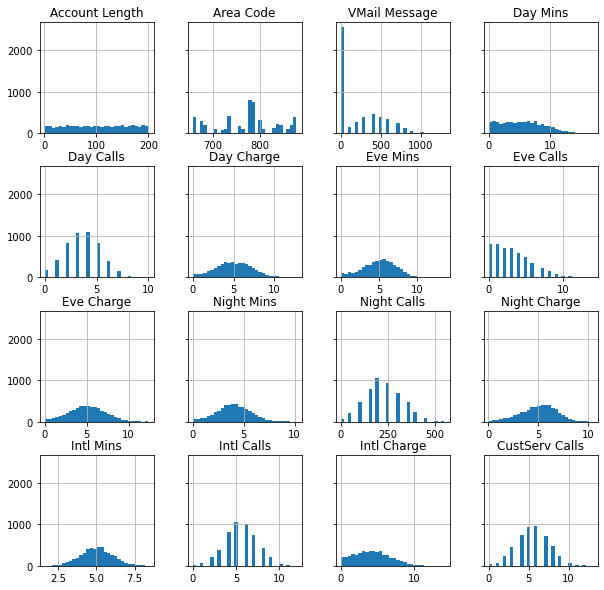

In [13]:
# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

We can see immediately that: - `State` appears to be quite evenly distributed. - `Phone` takes on too many unique values to be of any practical use. It’s possible that parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it. - Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity. `VMail Message` is a notable exception.

In [14]:
churn = churn.drop("Phone", axis=1)
churn["Area Code"] = churn["Area Code"].astype(object)

Next let’s look at the relationship between each of the features and our target variable.

Churn?    False.     True.
State                     
AK      0.015588  0.018415
AL      0.021583  0.018415
AR      0.022782  0.021217
AZ      0.015588  0.020416
CA      0.020384  0.021217
CO      0.018785  0.017614
CT      0.015588  0.020016
DC      0.022382  0.022418
DE      0.018385  0.018014
FL      0.019984  0.015612
GA      0.017986  0.015212
HI      0.019185  0.018815
IA      0.018385  0.022818
ID      0.021583  0.022818
IL      0.021982  0.017614
IN      0.021583  0.016413
KS      0.014788  0.016813
KY      0.017186  0.019215
LA      0.020783  0.019616
MA      0.021183  0.020416
MD      0.019584  0.025620
ME      0.013589  0.016013
MI      0.018785  0.021617
MN      0.022782  0.021217
MO      0.020783  0.021617
MS      0.019584  0.022818
MT      0.017586  0.018415
NC      0.017186  0.020817
ND      0.017186  0.014812
NE      0.019185  0.024420
NH      0.019984  0.017614
NJ      0.022382  0.018014
NM      0.017186  0.016013
NV      0.023181  0.016413
NY      0.015188  0.024019
O

Churn?       False.     True.
Area Code                    
657        0.037170  0.036829
658        0.022782  0.021217
659        0.015588  0.020416
676        0.020384  0.021217
677        0.018785  0.017614
678        0.015588  0.020016
686        0.040767  0.040432
707        0.019984  0.015612
716        0.017986  0.015212
727        0.019185  0.018815
736        0.039968  0.045637
737        0.043565  0.034027
758        0.031974  0.036029
766        0.020783  0.019616
776        0.054357  0.062050
777        0.062350  0.064452
778        0.037170  0.041233
786        0.053557  0.060048
787        0.059552  0.051641
788        0.038369  0.040432
797        0.040368  0.041233
798        0.019185  0.021617
806        0.018785  0.020817
827        0.024380  0.023619
836        0.043165  0.042834
847        0.021982  0.016813
848        0.019185  0.020016
858        0.018385  0.019616
866        0.021183  0.018415
868        0.022382  0.016413
876        0.021982  0.018415
877       

Churn?      False.     True.
Int'l Plan                  
no             0.5  0.502802
yes            0.5  0.497198

Churn?        False.     True.
VMail Plan                    
no          0.496403  0.498799
yes         0.503597  0.501201

Account Length


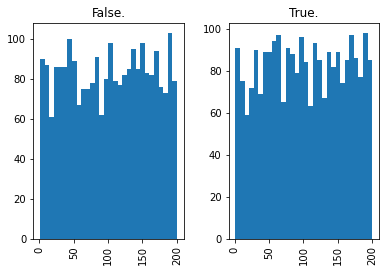

VMail Message


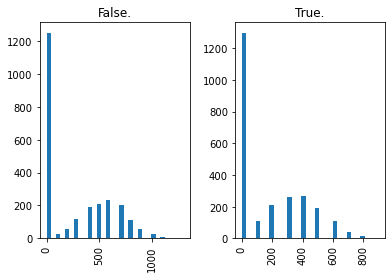

Day Mins


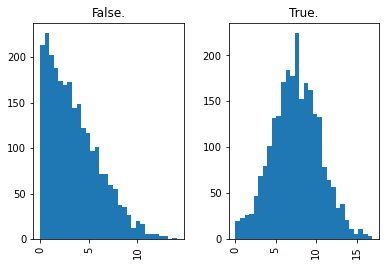

Day Calls


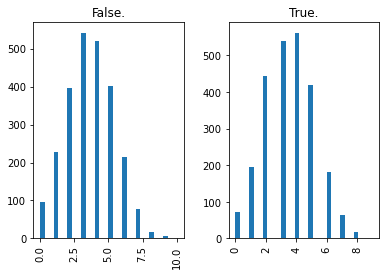

Day Charge


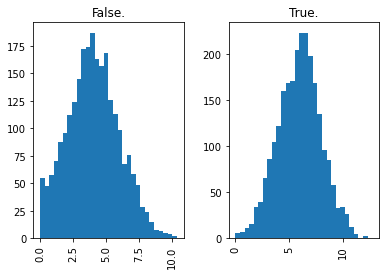

Eve Mins


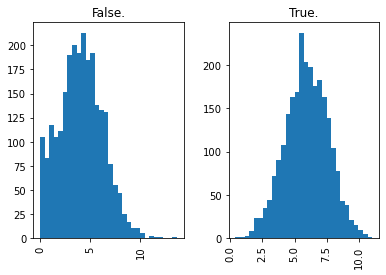

Eve Calls


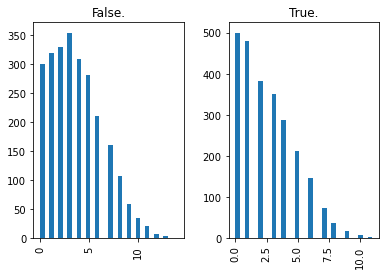

Eve Charge


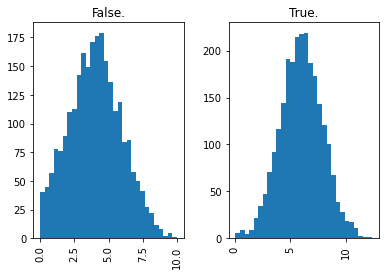

Night Mins


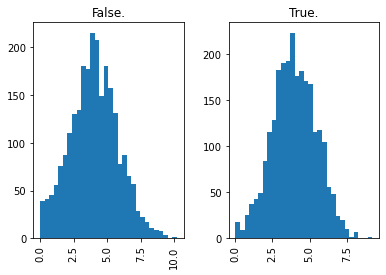

Night Calls


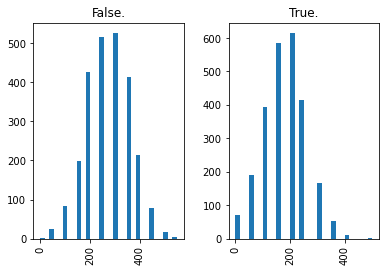

Night Charge


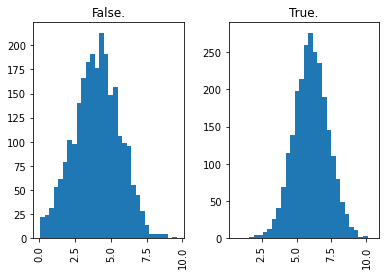

Intl Mins


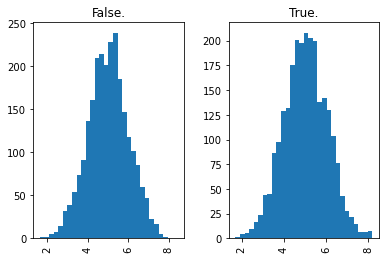

Intl Calls


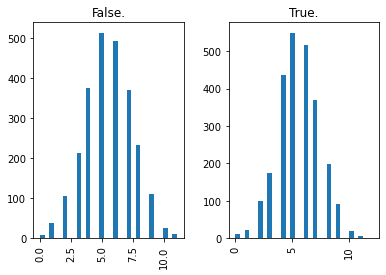

Intl Charge


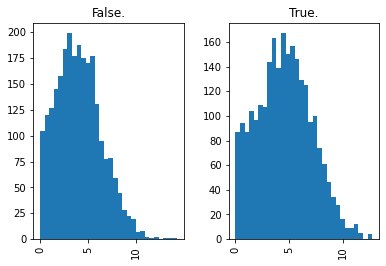

CustServ Calls


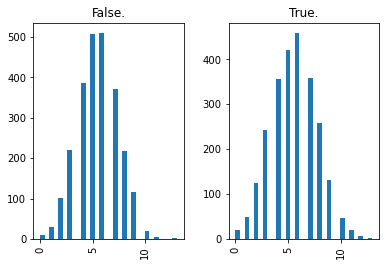

In [15]:
for column in churn.select_dtypes(include=["object"]).columns:
    if column != "Churn?":
        display(pd.crosstab(index=churn[column], columns=churn["Churn?"], normalize="columns"))

for column in churn.select_dtypes(exclude=["object"]).columns:
    print(column)
    hist = churn[[column, "Churn?"]].hist(by="Churn?", bins=30)
    plt.show()

We convert the target attribute to binary value and move it to the first column of the dataset to meet requirements of SageMaker built-in tabular algorithms (For an example, see [SageMaker LightGBM documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/lightgbm.html)).

In [16]:
churn["target"] = churn["Churn?"].map({"True.": 1, "False.": 0})
churn.drop(["Churn?"], axis=1, inplace=True)

In [17]:
churn = churn[["target"] + churn.columns.tolist()[:-1]]

We identify the column indexes of the categorical attribute, which is required by LightGBM, CatBoost, and TabTransformer algorithm (AutoGluon-Tabular has built-in feature engineering to identify the categorical attribute automatically, and thus does not require such input).

In [18]:
cat_columns = [
    "State",
    "Account Length",
    "Area Code",
    "Phone",
    "Int'l Plan",
    "VMail Plan",
    "VMail Message",
    "Day Calls",
    "Eve Calls",
    "Night Calls",
    "Intl Calls",
    "CustServ Calls",
]

cat_idx = []
for idx, col_name in enumerate(churn.columns.tolist()):
    if col_name in cat_columns:
        cat_idx.append(idx)

In [19]:
with open("cat_idx.json", "w") as outfile:
    json.dump({"cat_idx": cat_idx}, outfile)

[LightGBM official documentation](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#categorical-feature-support) requires that all categorical features should be encoded as non-negative integers. We do it consistently for all the other algorithms.

In [20]:
for idx, col_name in enumerate(churn.columns.tolist()):
    if col_name in cat_columns:
        le = preprocessing.LabelEncoder()
        churn[col_name] = le.fit_transform(churn[col_name])

We split the churn dataset into train, validation, and test set using stratified sampling. Validation set is used for early stopping and AMT. Test set is used for performance evaluations in the end. Next, we upload them into a S3 path for training.

The structure of the S3 path for training should be structured as below. The `cat_idx.json` is categorical column indexes.

-- `train`<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-- `data.csv`<br>
-- `validation`<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-- `data.csv`    
-- `cat_idx.json`

In [21]:
from sklearn.model_selection import train_test_split

train, val_n_test = train_test_split(
    churn, test_size=0.3, random_state=42, stratify=churn["target"]
)

In [22]:
val, test = train_test_split(
    val_n_test, test_size=0.3, random_state=42, stratify=val_n_test["target"]
)

In [23]:
train.to_csv("train.csv", header=False, index=False)
val.to_csv("validation.csv", header=False, index=False)
test.to_csv("test.csv", header=False, index=False)

In [24]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    f"{prefix}/train/data.csv"
).upload_file("train.csv")

In [25]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    f"{prefix}/validation/data.csv"
).upload_file("validation.csv")

In [26]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    f"{prefix}/test/data.csv"
).upload_file("test.csv")

In [27]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    f"{prefix}/cat_idx.json"
).upload_file("cat_idx.json")

## 3. Train A LightGBM Model with AMT

### 3.1. Retrieve Training Artifacts

___

Here, we retrieve the training docker container, the training algorithm source, and the tabular algorithm. Note that model_version="*" fetches the latest model.

For the training algorithm, we have four choices in this demonstration for classification task.
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/): To use this algorithm, specify `train_model_id` as `lightgbm-classification-model` in the cell below.
* [CatBoost](https://catboost.ai/en/docs/): To use this algorithm, specify `train_model_id` as `catboost-classification-model` in the cell below.
* [TabTransformer](https://arxiv.org/abs/2012.06678): To use this algorithm, specify `train_model_id` as `pytorch-tabtransformerclassification-model` in the cell below.
* [AutoGluon Tabular](https://auto.gluon.ai/stable/tutorials/tabular_prediction/index.html): To use this algorithm, specify `train_model_id` as `autogluon-classification-ensemble` in the cell below.

Note. [XGBoost](https://xgboost.readthedocs.io/en/latest/) (`train_model_id: xgboost-classification-model`) and [Linear Learner](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (`train_model_id: sklearn-classification-linear`) are the other choices in the tabular classification category. Since they have different input-format requirements, please check separate notebooks `xgboost_linear_learner_tabular/Amazon_Tabular_Classification_XGBoost_LinearLearner.ipynb`, `tabtransformer_tabular/Amazon_Tabular_Classification_TabTransformer.ipynb`, and `autogluon_tabular/Amazon_Tabular_Classification_AutoGluon.ipynb` for details.

For regression task, you just need replace `classification` in the `train_model_id` with `regression`.


---

In [28]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = "lightgbm-classification-model", "*", "training"
training_instance_type = "ml.m5.4xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

### 3.2. Set Training Parameters

---

Now that we are done with all the setup that is needed, we are ready to train our tabular algorithm. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training.

The second set of parameters are algorithm specific training hyper-parameters. 

---

In [29]:
training_dataset_s3_path = f"s3://{bucket}/{prefix}"

s3_output_location_lgb = f"s3://{bucket}/{prefix}/output/lgb"

---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values. For the evaluation metric that is used by early stopping and automatic model tuning, we choose `auc` score. Note. LightGBM does not have built-in F1 score supported. See [LightGBM documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters).

---

In [30]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters[
    "num_boost_round"
] = "500"  # The same hyperparameter is named as "iterations" for CatBoost


hyperparameters["metric"] = "auc"
print(hyperparameters)

{'num_boost_round': '500', 'early_stopping_rounds': '30', 'metric': 'auc', 'learning_rate': '0.009', 'num_leaves': '67', 'feature_fraction': '0.74', 'bagging_fraction': '0.53', 'bagging_freq': '5', 'max_depth': '11', 'min_data_in_leaf': '26', 'max_delta_step': '0.0', 'lambda_l1': '0.0', 'lambda_l2': '0.0', 'boosting': 'gbdt', 'min_gain_to_split': '0.0', 'scale_pos_weight': '1.0', 'tree_learner': 'serial', 'feature_fraction_bynode': '1.0', 'is_unbalance': 'False', 'max_bin': '255', 'num_threads': '0', 'verbosity': '1', 'use_dask': 'False'}


### 3.3. Train with Automatic Model Tuning  


Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. We will use a HyperparameterTuner object to interact with Amazon SageMaker hyperparameter tuning APIs.

* Note. In this notebook, we set AMT budget (total tuning jobs) as 10 for each of the tabular algorithm except AutoGluon-Tabular. For [AutoGluon-Tabular](https://arxiv.org/abs/2003.06505), it succeeds by ensembling multiple models and stacking them in multiple layers.  

In [31]:
from sagemaker.tuner import ContinuousParameter, IntegerParameter, HyperparameterTuner

use_amt = True

hyperparameter_ranges_lgb = {
    "learning_rate": ContinuousParameter(1e-4, 1, scaling_type="Logarithmic"),
    "num_boost_round": IntegerParameter(2, 30),
    "num_leaves": IntegerParameter(10, 50),
    "feature_fraction": ContinuousParameter(0, 1),
    "bagging_fraction": ContinuousParameter(0, 1),
    "bagging_freq": IntegerParameter(1, 10),
    "max_depth": IntegerParameter(5, 30),
    "min_data_in_leaf": IntegerParameter(5, 50),
}

### 3.4. Start Training

---
We start by creating the estimator object with all the required assets and then launch the training job.

---

In [ ]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"{solution_prefix}-lgb")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location_lgb,
)

if use_amt:

    tuner = HyperparameterTuner(
        tabular_estimator,
        "auc",
        hyperparameter_ranges_lgb,
        [{"Name": "auc", "Regex": "auc: ([0-9\\.]+)"}],
        max_jobs=50,
        max_parallel_jobs=5,
        objective_type="Maximize",
        base_tuning_job_name=training_job_name,
    )

    tuner.fit({"training": training_dataset_s3_path}, logs=True)
else:
    # Launch a SageMaker Training job by passing s3 path of the training data
    tabular_estimator.fit(
        {"training": training_dataset_s3_path}, logs=True, job_name=training_job_name
    )

...........................................

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


..............................................

### 3.5. Deploy and Run Inference on the Trained Tabular Model

---

In this section, you learn how to query an existing endpoint and make predictions of the examples you input. For each example, the model will output the probability of the sample for each class in the model. 
Next, the predicted class label is obtained by taking the class label with the maximum probability over others.


We start by retrieving the artifacts and deploy the `tabular_estimator` that we trained.

---

In [ ]:
inference_instance_type = "ml.m5.4xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = f"{solution_prefix}-lgb-endpoint"

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = (tuner if use_amt else tabular_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

---
Next, we read the customer churn test data into pandas data frame, prepare the ground truth target and predicting features to send into the endpoint. 

Below is the screenshot of the first 5 examples in the test set.

---

In [ ]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# read the data
test_data_file_name = "test.csv"
test_data = pd.read_csv(test_data_file_name, header=None)
test_data.columns = ["Target"] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(
    f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n"
)

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
test_data.head(5)

---
The following code queries the endpoint you have created to get the prediction for each test example. 
The `query_endpoint()` function returns an array-like of shape (num_examples, num_classes), where each row indicates 
the probability of the example for each class in the model. The num_classes is 2 in above test data. 
Next, the predicted class label is obtained by taking the class label with the maximum probability over others for each example. 

---

In [ ]:
content_type = "text/csv"


def query_endpoint(encoded_tabular_data, endpoint_name):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType=content_type,
        Body=encoded_tabular_data,
    )
    return response


def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = model_predictions["probabilities"]
    return np.array(predicted_probabilities)


# split the test data into smaller size of batches to query the endpoint if test data has large size.
batch_size = 1500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8"),
        endpoint_name,
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob.append(predict_prob_batch)


predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(predict_prob, axis=1)

## 3.6. Evaluate the Prediction Results Returned from the Endpoint

---
We evaluate the predictions results returned from the endpoint by following two ways.

* Visualize the predictions results by plotting the confusion matrix.

* Measure the prediction results quantitatively.

---

In [ ]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large")

plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()

In [ ]:
# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1 = f1_score(ground_truth_label.values, predict_label)
eval_auc = roc_auc_score(ground_truth_label.values, predict_prob[:, 1])

lgb_results = pd.DataFrame.from_dict(
    {
        "Accuracy": eval_accuracy,
        "F1": eval_f1,
        "AUC": eval_auc,
    },
    orient="index",
    columns=["LightGBM with AMT"],
)

lgb_results

## 4. Train A CatBoost model with AMT


### 4.1. Train with Automatic Model Tuning


Retrieve Training Artifacts

In [ ]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = "catboost-classification-model", "*", "training"
training_instance_type = "ml.m5.4xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

Set training parameters

In [ ]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["iterations"] = "500"


hyperparameters["eval_metric"] = "AUC"
print(hyperparameters)

In [ ]:
s3_output_location_cat = f"s3://{bucket}/{prefix}/output_cat"

Train with Automatic Model Tuning

In [ ]:
hyperparameter_ranges_cat = {
    "learning_rate": ContinuousParameter(0.00001, 0.1, scaling_type="Logarithmic"),
    "iterations": IntegerParameter(50, 1000),
    "depth": IntegerParameter(1, 10),
    "l2_leaf_reg": IntegerParameter(1, 10),
    "random_strength": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
}

Start training

In [ ]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"{solution_prefix}-cat")

# Create SageMaker Estimator instance
tabular_estimator_cat = Estimator(
    role=role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location_cat,
)

if use_amt:

    tuner_cat = HyperparameterTuner(
        tabular_estimator_cat,
        "AUC",
        hyperparameter_ranges_cat,
        [{"Name": "AUC", "Regex": "bestTest = ([0-9\\.]+)"}],
        max_jobs=50,
        max_parallel_jobs=5,
        objective_type="Maximize",
        base_tuning_job_name=training_job_name,
    )

    tuner_cat.fit({"training": training_dataset_s3_path}, logs=True)
else:
    # Launch a SageMaker Training job by passing s3 path of the training data
    tabular_estimator_cat.fit(
        {"training": training_dataset_s3_path}, logs=True, job_name=training_job_name
    )

### 4.2. Deploy and Run Inference on the Trained Tabular Model

In [ ]:
inference_instance_type = "ml.m5.4xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name_cat = f"{solution_prefix}-cat-endpoint"

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor_cat = (tuner_cat if use_amt else tabular_estimator_cat).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name_cat,
)

Query the endpoint

In [ ]:
# split the test data into smaller size of batches to query the endpoint if the test data has large size.
batch_size = 1500
predict_prob_cat = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8"),
        endpoint_name_cat,
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob_cat.append(predict_prob_batch)


predict_prob_cat = np.concatenate(predict_prob_cat, axis=0)
predict_label_cat = np.argmax(predict_prob_cat, axis=1)

Evaluate the prediction results returned from the endpoint

In [ ]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label_cat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large")

plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()

In [ ]:
# Measure the prediction results quantitatively.
eval_accuracy_cat = accuracy_score(ground_truth_label.values, predict_label_cat)
eval_f1_cat = f1_score(ground_truth_label.values, predict_label_cat)
eval_auc_cat = roc_auc_score(ground_truth_label.values, predict_prob_cat[:, 1])

cat_results = pd.DataFrame.from_dict(
    {
        "Accuracy": eval_accuracy_cat,
        "F1": eval_f1_cat,
        "AUC": eval_auc_cat,
    },
    orient="index",
    columns=["CatBoost with AMT"],
)

results_lab_cat = pd.concat([lgb_results, cat_results], axis=1)
results_lab_cat

## 5. Train A TabTransformer model with AMT

### 5.1. Train with Automatic Model Tuning

Retrieve Training Artifacts

In [ ]:
train_model_id, train_model_version, train_scope = (
    "pytorch-tabtransformerclassification-model",
    "*",
    "training",
)
training_instance_type = "ml.g4dn.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

Set training parameters

In [ ]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["n_epochs"] = 40  # The same hyperparameter is named as "iterations" for CatBoost
hyperparameters["patience"] = 10

print(hyperparameters)

In [ ]:
s3_output_location_tab = f"s3://{bucket}/{prefix}/output_tt"

Train with Automatic Model Tuning

In [ ]:
from sagemaker.tuner import (
    ContinuousParameter,
    IntegerParameter,
    HyperparameterTuner,
    CategoricalParameter,
)

hyperparameter_ranges_tab = {
    "learning_rate": ContinuousParameter(0.001, 0.01, scaling_type="Auto"),
    "batch_size": CategoricalParameter([64, 128, 256, 512]),
    "attn_dropout": ContinuousParameter(0.0, 0.8, scaling_type="Auto"),
    "mlp_dropout": ContinuousParameter(0.0, 0.8, scaling_type="Auto"),
    "input_dim": CategoricalParameter(["16", "32", "64", "128", "256"]),
    "frac_shared_embed": ContinuousParameter(0.0, 0.5, scaling_type="Auto"),
}

Start training

In [ ]:
training_job_name =  name_from_base(f"{solution_prefix}-tt")

# Create SageMaker Estimator instance
tabular_estimator_tab = Estimator(
    role=role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location_tab,
)

if use_amt:

    tuner_tab = HyperparameterTuner(
        tabular_estimator_tab,
        "f1_score",  # Note, TabTransformer currently does not support AUC score, thus we use its default setting F1 score as an alternative evaluation metric.
        hyperparameter_ranges_tab,
        [{"Name": "f1_score", "Regex": "metrics={'f1': (\\S+)}"}],
        max_jobs=50,
        max_parallel_jobs=5,  # reduce max_parallel_jobs number if the instance type is limited in your account
        objective_type="Maximize",
        base_tuning_job_name=training_job_name,
    )

    tuner_tab.fit({"training": training_dataset_s3_path}, logs=True)
else:
    # Launch a SageMaker Training job by passing s3 path of the training data
    tabular_estimator_tab.fit(
        {"training": training_dataset_s3_path}, logs=True, job_name=training_job_name
    )

    
### 5.2. Deploy and Run Inference on the Trained Tabular Model

In [ ]:
inference_instance_type = "ml.m5.4xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name_tab =  f"{solution_prefix}-tt-endpoint"

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor_tab = (tuner_tab if use_amt else tabular_estimator_tab).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name_tab,
)

In [ ]:
# split the test data into smaller size of batches to query the endpoint if the test data has large size.
batch_size = 1500
predict_prob_tab = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8"),
        endpoint_name_tab,
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob_tab.append(predict_prob_batch)


predict_prob_tab = np.concatenate(predict_prob_tab, axis=0)
predict_label_tab = np.argmax(predict_prob_tab, axis=1)

Evaluate the prediction results returned from the endpoint

In [ ]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label_tab)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large")

plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()

In [ ]:
# Measure the prediction results quantitatively.
eval_accuracy_tab = accuracy_score(ground_truth_label.values, predict_label_tab)
eval_f1_tab = f1_score(ground_truth_label.values, predict_label_tab)
eval_auc_tab = roc_auc_score(ground_truth_label.values, predict_prob_tab[:, 1])

tab_results = pd.DataFrame.from_dict(
    {
        "Accuracy": eval_accuracy_tab,
        "F1": eval_f1_tab,
        "AUC": eval_auc_tab,
    },
    orient="index",
    columns=["TabTransformer with AMT"],
)

results_lab_cat_tab = pd.concat([results_lab_cat, tab_results], axis=1)
results_lab_cat_tab

## 6. Train An AutoGluon-Tabular model

### 6.1. Train with AutoGluon-Tabular model


Retrieve Training Artifacts

In [ ]:
from sagemaker import image_uris, model_uris, script_uris

# Currently, not all the object detection models in jumpstart support finetuning. Thus, we manually select a model
# which supports finetuning.
train_model_id, train_model_version, train_scope = (
    "autogluon-classification-ensemble",
    "*",
    "training",
)
training_instance_type = "ml.g4dn.2xlarge"  # set a different GPU type to avoid instance insufficiency for p3 instance that is used by TabTransformer

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

Set training parameters

In [ ]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

hyperparameters["eval_metric"] = "roc_auc"
print(hyperparameters)

In [ ]:
s3_output_location_ag = f"s3://{bucket}/{prefix}/output_ag"

Start training

Note. We do not perform automatic model tuning as AutoGluon-Tabular do not focus on hyperparameter selections. Instead, it ensembles multiple models and stacks them in multiple layers. For details, see [paper](https://arxiv.org/abs/2003.06505).

In [ ]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"{solution_prefix}-ag")

# Create SageMaker Estimator instance
tabular_estimator_ag = Estimator(
    role=role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location_ag,
)


# Launch a SageMaker Training job by passing s3 path of the training data
tabular_estimator_ag.fit(
    {"training": training_dataset_s3_path}, logs=True, job_name=training_job_name
)

### 6.2. Deploy and Run Inference on the Trained Tabular Model

In [ ]:
inference_instance_type = "ml.m5.4xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name_ag = f"{solution_prefix}-ag-endpoint"

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor_ag = tabular_estimator_ag.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name_ag,
)

In [ ]:
# split the test data into smaller size of batches to query the endpoint if the test data has large size.
batch_size = 1500
predict_prob_ag = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8"),
        endpoint_name_ag,
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob_ag.append(predict_prob_batch)


predict_prob_ag = np.concatenate(predict_prob_ag, axis=0)
predict_label_ag = np.argmax(predict_prob_ag, axis=1)

In [ ]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label_ag)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large")

plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()

In [ ]:
# Measure the prediction results quantitatively.
eval_accuracy_ag = accuracy_score(ground_truth_label.values, predict_label_ag)
eval_f1_ag = f1_score(ground_truth_label.values, predict_label_ag)
eval_auc_ag = roc_auc_score(ground_truth_label.values, predict_prob_ag[:, 1])

ag_results = pd.DataFrame.from_dict(
    {
        "Accuracy": eval_accuracy_ag,
        "F1": eval_f1_ag,
        "AUC": eval_auc_ag,
    },
    orient="index",
    columns=["AutoGluon-Tabular"],
)

results_lab_cat_tab_ag = pd.concat([results_lab_cat_tab, ag_results], axis=1)
results_lab_cat_tab_ag

## 7. Compare Prediction Results of Four Trained Models on the Same Test Data

For the three evaluation metrics accuracy, f1 score, and roc_auc, larger value indicates better results. 

In [ ]:
results_lab_cat_tab_ag

Now you can use this template to evaluate the performance of LightGBM, CatBoost, TabTransformer, and AutoGluon-Tabular on your own dataset.

---
Next, we delete the endpoint corresponding to the trained model.

---

In [ ]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()
predictor_cat.delete_model()
predictor_cat.delete_endpoint()
predictor_tab.delete_model()
predictor_tab.delete_endpoint()
predictor_ag.delete_model()
predictor_ag.delete_endpoint()